## SI Sentiment

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data SI

In [3]:
df = pd.read_csv("new_data/amalsholeh_SI_sentiment.csv")
df.head()

content    SI  value sentiment
0  Assalamu'alaikum Alhamdulillah AmalSholeh suda...  True      1   positif
1  Sering bingung jika ada iklan di facebook sepu...  True      1   positif
2  MasyaAllah, salah satu aplikasi yang recommend...  True      1   positif
3  Alhamdulillah dengan adanya aplikasi amalshole...  True      1   positif
4  MasyaAllah, bener bener mempermudah banget kal...  True      1   positif

In [4]:
df.sentiment.value_counts()

positif    64
negatif     1
Name: sentiment, dtype: int64

In [5]:
df.sentiment.value_counts(normalize=True)

positif    0.984615
negatif    0.015385
Name: sentiment, dtype: float64

### Encoding with W2V Model

In [6]:
from gensim.models import Word2Vec

In [7]:
w2v = Word2Vec.load("model/w2v/amalsholeh_review.w2v").wv

In [8]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    
    
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [9]:
vecs.shape

(65, 200)

### Dataset Splitting

In [10]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

### Dummy Data Import Data

In [11]:
df = pd.read_csv("new_data/amalsholeh_SI_sentiment_dummy.csv")
df.head()

content sentiment
0  Assalamu'alaikum Alhamdulillah AmalSholeh suda...   positif
1  Sering bingung jika ada iklan di facebook sepu...   positif
2  MasyaAllah, salah satu aplikasi yang recommend...   positif
3  Alhamdulillah dengan adanya aplikasi amalshole...   positif
4  MasyaAllah, bener bener mempermudah banget kal...   positif

In [12]:
df.sentiment.value_counts()

positif    64
negatif    45
Name: sentiment, dtype: int64

In [13]:
df.sentiment.value_counts(normalize=True)

positif    0.587156
negatif    0.412844
Name: sentiment, dtype: float64

### Encoding with W2V Model

In [14]:
from gensim.models import Word2Vec

In [15]:
w2v = Word2Vec.load("model/w2v/amalsholeh_review.w2v").wv

In [16]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    
    
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

### Dataset Splitting

In [17]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((87, 200), (22, 200), (87,), (22,))

### Training SVM

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [20]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 1.0, 'algo__gamma': 1.0}
0.9770114942528736 0.9425287356321839 0.8636363636363636


### Evaluation

In [21]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

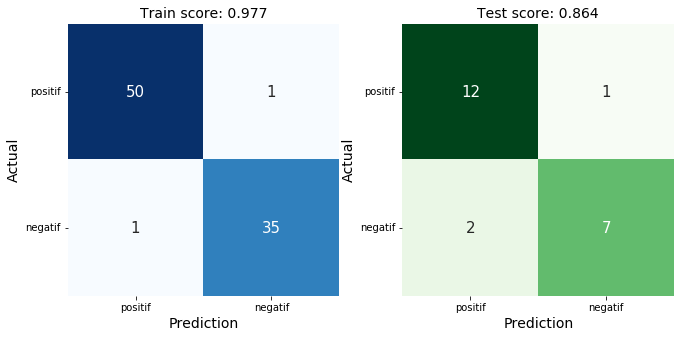

In [22]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [23]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

     negatif       0.97      0.97      0.97        36
     positif       0.98      0.98      0.98        51

    accuracy                           0.98        87
   macro avg       0.98      0.98      0.98        87
weighted avg       0.98      0.98      0.98        87


Test report
              precision    recall  f1-score   support

     negatif       0.88      0.78      0.82         9
     positif       0.86      0.92      0.89        13

    accuracy                           0.86        22
   macro avg       0.87      0.85      0.86        22
weighted avg       0.86      0.86      0.86        22



### Encoding with FastText

In [24]:
from gensim.models import FastText

In [25]:
fastText = FastText.load("model/fasttext/amalsholeh_review.fasttext").wv

In [26]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, fastText, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [27]:
vecs.shape

(109, 200)

### Dataset Splitting

In [28]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((87, 200), (22, 200), (87,), (22,))

### Training with SVM

In [29]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 1.0, 'algo__gamma': 1.0}
0.9770114942528736 0.9425287356321839 0.8636363636363636


### Evaluation

In [30]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

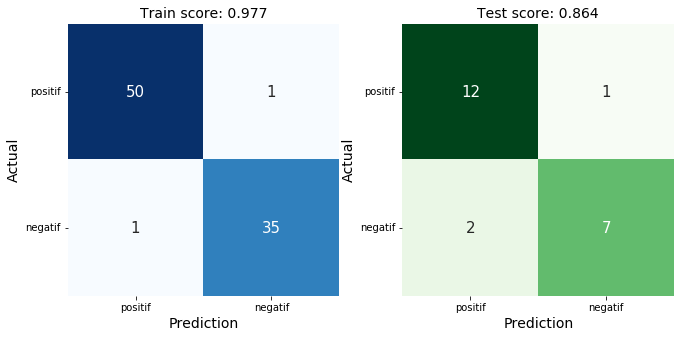

In [31]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [32]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

     negatif       0.97      0.97      0.97        36
     positif       0.98      0.98      0.98        51

    accuracy                           0.98        87
   macro avg       0.98      0.98      0.98        87
weighted avg       0.98      0.98      0.98        87


Test report
              precision    recall  f1-score   support

     negatif       0.88      0.78      0.82         9
     positif       0.86      0.92      0.89        13

    accuracy                           0.86        22
   macro avg       0.87      0.85      0.86        22
weighted avg       0.86      0.86      0.86        22

